<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DSI 37 Project 3

<a id='part_iii'></a>
[Part I](Part_1-Reddit_API_access_and_scraping.ipynb#part_i) <br>
[Part II](Part_2-Cleaning_and_EDA.ipynb#part_ii)

# Part III: Modelling

<a id='part_iii'></a>

## Contents

[1. Imports (Libraries)](#imports)<br>
[2. Imports (Data)](#data_imports)<br>
[3. Train-Test-Split](#train_test_split)<br>
[4. Modelling](#modelling)<br>
[5. Insights](#insights)<br>
[6. Business Recommendations](#biz_rec)<br>
[7. Conclusion](#conclusion)<br>



## 1. Imports (Libraries)

<a id='imports'></a>

In [1]:
# Import basic libraries
import pandas as pd
import numpy as np

In [2]:
# Import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import NLP libraries
import re
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer # If doing sentiment analysis

In [4]:
from gensim.models import Word2Vec

In [5]:
# Import sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [6]:
import shap

In [7]:
# some display adjustments to account for the fact that we have many columns
# and some columns contain many characters

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)

## 2. Imports (Data)

<a id='data_imports'></a>

Since we exported the cleaned dataset as a csv file in Part II, we can simply import that file and start working on it immediately. The two columns we are most concerned with are 'redditlabel' and 'text_lemma'.

Data dictionary:

|column| datatype|explanation|
|:-|:-:|:-|
|<b>redditlabel</b>|*integer*| The numeric boolean representation of our two classes. 0 means Keto and 1 means Paleo.|
|<b>title</b>| *string*| The subject title of the Reddit post.|
|<b>selftext</b>| *string*| The content of the Reddit post.|
|<b>titletext</b>| *string*| The combined text from 'title' and 'selftext'.|
|<b>text_clean</b>| *string*| The text from 'titletext'  in lowercase and with the punctuation removed.|
|<b>char_count</b>| *integer*| The number of characters in 'text_clean' (including spaces).|
|<b>word_count</b>| *integer*| The number of words in 'text_clean' (not including spaces).|
|<b>text_lemma</b>| *string*| The lemmatized text from 'text_clean'.|

<br>

In [8]:
kp_df = pd.read_csv('data/combined.csv', lineterminator='\n')

In [9]:
kp_df.shape

(1905, 8)

In [10]:
kp_df.head(2)

,redditlabel,title,selftext,titletext,text_clean,char_count,word_count,text_lemma
0,0,Does Keto have benefits without fasting?,"I enjoy how I feel when I’m consistent with a Keto style diet, but I don’t enjoy fasting. All th...",Does Keto have benefits without fasting? I enjoy how I feel when I’m consistent with a Keto styl...,does keto have benefits without fasting i enjoy how i feel when i m consistent with a keto style...,972,196,do keto have benefit without fast i enjoy how i feel when i m consistent with a keto style diet ...
1,0,Lazy keto,"Hi all, I'm back on keto after a break and I'm feeling good :) \n\nI'm super lazy when it comes ...","Lazy keto Hi all, I'm back on keto after a break and I'm feeling good :) \n\nI'm super lazy when...",lazy keto hi all im back on keto after a break and im feeling good im super lazy when it come...,433,87,lazy keto hi all im back on keto after a break and im feel good im super lazy when it come to ma...


## 3. Train-test-split

<a id='train_test_split'></a>

We did all our modelling using the same train-test-split through the use of pipelines. 

In [11]:
# Checking for class imbalance

data_df = pd.DataFrame()
data_df['Number of Posts'] = kp_df['redditlabel'].value_counts()
data_df['Percent of Posts'] = kp_df['redditlabel'].value_counts(normalize=True)*100 
data_df.index = ['Keto', 'Paleo']

data_df

,Number of Posts,Percent of Posts
Keto,976,51.233596
Paleo,929,48.766404


The classes are relatively balanced (<5% difference).

In [32]:
stopwords = nltk.corpus.stopwords.words('english')
extrawords = ['pinned','top','subreddit','ask','question','ha','beginner','hello',
              'talk','wa','also','ive','im','use','community', 'want','would','think','really', 'nutshell', 'utshell', 'support','thread']
stopwords.extend(extrawords)

# function to remove stopwords 
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(filtered_words)

# Apply the function to the 'lemma_text' column
kp_df['text_lemma'] = kp_df['text_lemma'].apply(remove_stopwords)

In [33]:
# Defining X and y
X = kp_df['text_lemma']
y = kp_df['redditlabel']


There are no missing labels.

In [34]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    random_state=42)

print(f'The X train set is {X_train.shape[0]} rows long.')
print(f'The y train set is {y_train.shape[0]} rows long.')
print(f'The X test set is {X_test.shape[0]} rows long.')
print(f'The y test set is {y_test.shape[0]} rows long.')


The X train set is 1428 rows long.
The y train set is 1428 rows long.
The X test set is 477 rows long.
The y test set is 477 rows long.


## 4. Modelling

<a id='modelling'></a>

In this section we go through 11 different models. To minimise run time, we have taken our best results from GridSearch and included the original hyperparameter options as comments.

The metric we have chosen to use to evaluate our models is the f1 score because for our purposes it is equally important to identify both classes. 

Here is a sub-chapter contents page for the models we ran:

### Contents - Models
[Baseline Model - Word2Vec with Logistic Regression](#w2vec_lr)<br><br>

[TfidfVectorizer](#tfidf)<br>
[Model 1 - TfidfVectorizer with KNNeighbours](#tfidf_knn)<br>
[Model 2 - TfidfVectorizer with Bernoulli Naive Bayes](#tfidf_bnb)<br>
[Model 3 - TfidfVectorizer with Multinomial Naive Bayes](#tfidf_mnb)<br>
[Model 4 - TfidfVectorizer with Gaussian Naive Bayes](#tfidf_gnb)<br>
[Model 5 - TfidfVectorizer with Logistic Regression](#tfidf_lr)<br><br>

[CountVectorizer](#cv)<br>
[Model 6 - CountVectorizer with KNNeighbours](#cv_knn)<br>
[Model 7 - CountVectorizer with Bernoulli Naive Bayes](#cv_bnb)<br>
[Model 8 - CountVectorizer with Multinomial Naive Bayes](#cv_mnb)<br>
[Model 9 - CountVectorizer with Gaussian Naive Bayes](#cv_gnb)<br>
[Model 10 - CountVectorizer with Logistic Regression](#cv_lr)<br><br>

[Summary](#summary)

### Baseline Model - Word2Vec with Logistic Regression

<a id='w2vec_lr'></a>

In [48]:
w2v_model = Word2Vec(X_train.str.split(), vector_size=100, window=5, min_count=2)


In [49]:
# create a list to store the average of all word vectors for each row of data
row_vect_list = []

# Iterate through each row in X train data
for row in X_train.str.split():

    row_vector = [w2v_model.wv.get_vector(token) for token in row if token in w2v_model.wv]
    
    if row_vector:
        row_vector = np.mean(row_vector, axis=0).tolist()
    else:
        row_vector = np.zeros(100).tolist()
    
    row_vect_list.append(row_vector)
        
word2vec_df = pd.DataFrame(row_vect_list)


In [50]:
# Instantiating and fitting the model
model_word2vec = LogisticRegression()
model_word2vec.fit(word2vec_df, y_train)


LogisticRegression()

In [51]:
# Evaluating the model
test_row_vect_list = []

for row in X_test.str.split():
    row_vector = [w2v_model.wv.get_vector(token) for token in row if token in w2v_model.wv]

    if row_vector:
        row_vector = np.mean(row_vector, axis=0).tolist()
    else:
        row_vector = np.zeros(100).tolist()
        
    test_row_vect_list.append(row_vector)


y_pred = model_word2vec.predict(test_row_vect_list)


In [52]:
# Metrics
binary_f1 = f1_score(y_test, y_pred, average='binary')

print(f'The f1 score for the baseline model is {binary_f1:.3f}.')


The f1 score for the baseline model is 0.653.


We can see that while the model is not great, it still helps us to identify whether it is keto or paleo in 65.3% of cases, which is better than a random guess (a 50% chance of getting it right).

### TfidfVectorizer Models

<a id='tfidf'></a>

### 1. TfidfVectorizer-KNN

<a id='tfidf_knn'></a>

In [53]:
# Fitting the model
pipe_tfidf_knn = Pipeline(steps=[('tvec', TfidfVectorizer()),
                                ('knn', KNeighborsClassifier())])

pipe_tfidf_knn_params = {'tvec__max_features':[4000], #2000, 3000, 4000, 5000
                        'tvec__min_df':[3], #2, 3
                        'tvec__max_df':[.90], #.90, .95
                        'tvec__ngram_range':[(1,2)], #(1,1), (1,2), (2,2)
                        'knn__n_neighbors': [41], #list(range(1,51,10))
                        'knn__metric': ['euclidean']} #'euclidean', 'manhattan'

gs_tfidf_knn = GridSearchCV(pipe_tfidf_knn, param_grid=pipe_tfidf_knn_params, scoring = 'f1', cv=3)

gs_tfidf_knn.fit(X_train, y_train)



GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean'], 'knn__n_neighbors': [41],
                         'tvec__max_df': [0.9], 'tvec__max_features': [4000],
                         'tvec__min_df': [3], 'tvec__ngram_range': [(1, 2)]},
             scoring='f1')

In [54]:
# Making predictions
train_y_pred_tfidf_knn = gs_tfidf_knn.predict(X_train)
y_pred_tfidf_knn = gs_tfidf_knn.predict(X_test)


In [55]:
# Metrics
binary_f1_train = f1_score(y_train, train_y_pred_tfidf_knn, average='binary')
binary_f1 = f1_score(y_test, y_pred_tfidf_knn, average='binary')

print(f'The f1 train score for model 1 is {binary_f1_train:.3f}.')
print(f'The f1 test score for model 1 is {binary_f1:.3f}.')


The f1 train score for model 1 is 0.859.
The f1 test score for model 1 is 0.881.


### 2. TfidfVectorizer-Bernoulli NB

<a id='tfidf_bnb'></a>

In [56]:
# Fitting the model
pipe_tfidf_bnb = Pipeline(steps=[('tvec', TfidfVectorizer()),
                                  ('bern', BernoulliNB())])

pipe_tfidf_bnb_params = {'tvec__max_features':[3000], #2000, 3000, 4000, 5000
                         'tvec__min_df':[3], #2, 3
                         'tvec__max_df':[.90], #.90, .95
                         'tvec__ngram_range':[(1,2)], #(1,1), (1,2), (2,2)
                         'bern__binarize': [0.1]} #np.arange(0, 0.5, 0.1)

gs_tfidf_bnb = GridSearchCV(pipe_tfidf_bnb, param_grid=pipe_tfidf_bnb_params, cv=3)

gs_tfidf_bnb.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bern', BernoulliNB())]),
             param_grid={'bern__binarize': [0.1], 'tvec__max_df': [0.9],
                         'tvec__max_features': [3000], 'tvec__min_df': [3],
                         'tvec__ngram_range': [(1, 2)]})

In [57]:
# Making predictions
y_pred_tfidf_bnb_train = gs_tfidf_bnb.predict(X_train)
y_pred_tfidf_bnb = gs_tfidf_bnb.predict(X_test)


In [58]:
# Metrics
binary_f1_train = f1_score(y_train, y_pred_tfidf_bnb_train, average='binary')
binary_f1_test = f1_score(y_test, y_pred_tfidf_bnb, average='binary')

print(f'The f1 train score for model 2 is {binary_f1_train:.3f}.')
print(f'The f1 test score for model 2 is {binary_f1:.3f}.')

The f1 train score for model 2 is 0.927.
The f1 test score for model 2 is 0.881.


### 3. TfidfVectorizer-Multinomial NB

<a id='tfidf_mnb'></a>

In [59]:
# Fitting the model
pipe_tfidf_mnb = Pipeline(steps=[('tvec', TfidfVectorizer()),
                                  ('multi', MultinomialNB())])

pipe_tfidf_mnb_params = {'tvec__max_features':[2000], #2000, 3000, 4000, 5000
                         'tvec__min_df':[3], #2, 3
                         'tvec__max_df':[.90], #.90, .95
                         'tvec__ngram_range':[(1,2)]} #(1,1), (1,2), (2,2)

gs_tfidf_mnb = GridSearchCV(pipe_tfidf_mnb, param_grid=pipe_tfidf_mnb_params, cv=5)

gs_tfidf_mnb.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('multi', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9], 'tvec__max_features': [2000],
                         'tvec__min_df': [3], 'tvec__ngram_range': [(1, 2)]})

In [60]:
# Making predictions
y_pred_tfidf_mnb_train = gs_tfidf_mnb.predict(X_train)
y_pred_tfidf_mnb = gs_tfidf_mnb.predict(X_test)


In [61]:
# Metrics
binary_f1_train = f1_score(y_train, y_pred_tfidf_mnb_train, average='binary')
binary_f1 = f1_score(y_test, y_pred_tfidf_mnb, average='binary')

print(f'The f1 train score for model 3 is {binary_f1_train:.3f}.')
print(f'The f1 test score for model 3 is {binary_f1:.3f}.')

The f1 train score for model 3 is 0.923.
The f1 test score for model 3 is 0.848.


### 4. TfidfVectorizer-Gaussian NB

<a id='tfidf_gnb'></a>

In [62]:
# Fitting the model
sparse_to_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

pipe_tfidf_gnb = Pipeline(steps=[('tvec', TfidfVectorizer()),
                                 ('sparse_to_dense', sparse_to_dense),
                                 ('gaus', GaussianNB())])

pipe_tfidf_gnb_params = {'tvec__max_features':[3000], #2000, 3000, 4000, 5000
                         'tvec__min_df':[3], #2, 3
                         'tvec__max_df':[.90], #.90, .95
                         'tvec__ngram_range':[(1,2)]} #(1,1), (1,2), (2,2)

gs_tfidf_gnb = GridSearchCV(pipe_tfidf_gnb, param_grid=pipe_tfidf_gnb_params, cv=5)

gs_tfidf_gnb.fit(X_train.values, y_train.values)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('sparse_to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x2c171e440>)),
                                       ('gaus', GaussianNB())]),
             param_grid={'tvec__max_df': [0.9], 'tvec__max_features': [3000],
                         'tvec__min_df': [3], 'tvec__ngram_range': [(1, 2)]})

In [63]:
# Making predictions
y_pred_tfidf_gnb_train = gs_tfidf_gnb.predict(X_train)
y_pred_tfidf_gnb = gs_tfidf_gnb.predict(X_test)


In [64]:
# Metrics
binary_f1_train = f1_score(y_train, y_pred_tfidf_gnb_train, average='binary')
binary_f1 = f1_score(y_test, y_pred_tfidf_gnb, average='binary')

print(f'The f1 train score for model 4 is {binary_f1_train:.3f}.')
print(f'The f1 test score for model 4 is {binary_f1:.3f}.')

The f1 train score for model 4 is 0.963.
The f1 test score for model 4 is 0.820.


### 5. TfidfVectorizer-Logistic Regression

<a id='tfidf_lr'></a>

In [65]:
# Fitting the model
pipe_tfidf_lr = Pipeline(steps=[('tvec', TfidfVectorizer()),
                               ('logreg', LogisticRegression())])

pipe_tfidf_lr_params = {'tvec__max_features':[4000], #2000, 3000, 4000, 5000
                       'tvec__min_df':[2], #2, 3
                       'tvec__max_df':[.85], #.85, .90, .95
                       'tvec__ngram_range':[(1,3)], #(1,1), (1,2), (2,2), (1,3)
                       'logreg__C': [1]} #0.01, 0.1, 1

gs_tfidf_lr = GridSearchCV(pipe_tfidf_lr, param_grid=pipe_tfidf_lr_params, cv=3)

gs_tfidf_lr.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [1], 'tvec__max_df': [0.85],
                         'tvec__max_features': [4000], 'tvec__min_df': [2],
                         'tvec__ngram_range': [(1, 3)]})

In [66]:
# Making predictions
y_pred_tfidf_lr_train = gs_tfidf_lr.predict(X_train)
y_pred_tfidf_lr = gs_tfidf_lr.predict(X_test)
y_pred_proba_tfidf_lr = gs_tfidf_lr.predict_proba(X_test)


In [67]:
# Metrics
binary_f1_train = f1_score(y_train, y_pred_tfidf_lr_train, average='binary')
binary_f1 = f1_score(y_test, y_pred_tfidf_lr, average='binary')

print(f'The f1 train score for model 5 is {binary_f1_train:.3f}.')
print(f'The f1 test score for model 5 is {binary_f1:.3f}.')

The f1 train score for model 5 is 0.974.
The f1 test score for model 5 is 0.923.


### CountVectorizer Models

<a id='cv'></a>

### 6. CountVectorizer-KNN

<a id='cv_knn'></a>

In [68]:
pipe_cv_knn = Pipeline(steps=[('cvec', CountVectorizer()),
                                ('knn', KNeighborsClassifier())])

pipe_cv_knn_params = {'cvec__max_features':[2000], #2000, 3000, 4000, 5000
                        'cvec__min_df':[2], #2, 3
                        'cvec__max_df':[.90], #.90, .95
                        'cvec__ngram_range':[(1,1)], #(1,1),(1,2),(2,2)
                        'knn__n_neighbors': [1], #list(range(1,51,10))
                        'knn__metric': ['euclidean']} # 'euclidean', 'manhattan' 

gs_cv_knn = GridSearchCV(pipe_cv_knn, param_grid=pipe_cv_knn_params, cv=3)

gs_cv_knn.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [2000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 1)],
                         'knn__metric': ['euclidean'],
                         'knn__n_neighbors': [1]})

In [69]:
# Making predictions
y_pred_cv_knn_train = gs_cv_knn.predict(X_train)
y_pred_cv_knn = gs_cv_knn.predict(X_test)

In [70]:
# Metrics
binary_f1_train = f1_score(y_train, y_pred_cv_knn_train, average='binary')
binary_f1 = f1_score(y_test, y_pred_cv_knn, average='binary')

print(f'The f1 train score for model 6 is {binary_f1_train:.3f}.')
print(f'The f1 test score for model 6 is {binary_f1:.3f}.')

The f1 train score for model 6 is 1.000.
The f1 test score for model 6 is 0.750.


### 7. CountVectorizer-Bernoulli NB

<a id='cv_bnb'></a>

In [71]:
# Fitting the cv/bern model
pipe_cv_bnb = Pipeline(steps=[('cvec', CountVectorizer()),
                                 ('bern', BernoulliNB())])

pipe_cv_bnb_params = {'cvec__max_features':[4000], #2000, 3000, 4000, 5000
                         'cvec__min_df':[2], #2, 3
                         'cvec__max_df':[.90], #.90, .95
                         'cvec__ngram_range':[(1,1)], #(1,1),(1,2),(2,2)
                         'bern__binarize': [1]} #np.arange(0, 5, 1)

gs_cv_bnb = GridSearchCV(pipe_cv_bnb,
                           param_grid=pipe_cv_bnb_params,
                           cv=5)

gs_cv_bnb.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bern', BernoulliNB())]),
             param_grid={'bern__binarize': [1], 'cvec__max_df': [0.9],
                         'cvec__max_features': [4000], 'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1)]})

In [72]:
# Making predictions
y_pred_cv_bnb_train = gs_cv_bnb.predict(X_train)
y_pred_cv_bnb = gs_cv_bnb.predict(X_test)

In [73]:
# Metrics
binary_f1_train = f1_score(y_train, y_pred_cv_bnb_train, average='binary')
binary_f1 = f1_score(y_test, y_pred_cv_bnb, average='binary')

print(f'The f1 train score for model 7 is {binary_f1_train:.3f}.')
print(f'The f1 test score for model 7 is {binary_f1:.3f}.')

The f1 train score for model 7 is 0.841.
The f1 test score for model 7 is 0.813.


### 8. CountVectorizer-Multinomial NB

<a id='cv_mnb'></a>

In [74]:
# Fitting the model
pipe_cv_mnb = Pipeline(steps=[('cvec', CountVectorizer()),
                                  ('multi', MultinomialNB())])

pipe_cv_mnb_params = {'cvec__max_features':[4000], #2000, 3000, 4000, 5000
                         'cvec__min_df':[3], #2, 3
                         'cvec__max_df':[.90], #.90, .95
                         'cvec__ngram_range':[(1,2)]} #(1,1),(1,2),(2,2)

gs_cv_mnb = GridSearchCV(pipe_cv_mnb, param_grid=pipe_cv_mnb_params, cv=5)

gs_cv_mnb.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('multi', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [4000],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)]})

In [75]:
# Making predictions
y_pred_cv_mnb_train = gs_cv_mnb.predict(X_train)
y_pred_cv_mnb = gs_cv_mnb.predict(X_test)

In [76]:
# Metrics
binary_f1_train = f1_score(y_train, y_pred_cv_mnb_train, average='binary')
binary_f1 = f1_score(y_test, y_pred_cv_mnb, average='binary')

print(f'The f1 train score for model 8 is {binary_f1_train:.3f}.')
print(f'The f1 test score for model 8 is {binary_f1:.3f}.')

The f1 train score for model 8 is 0.932.
The f1 test score for model 8 is 0.893.


### 9. CountVectorizer-Gaussian NB

<a id='cv_gnb'></a>

In [77]:
# Fitting the model
sparse_to_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

pipe_cv_gnb = Pipeline(steps=[('cvec', CountVectorizer()),
                                 ('sparse_to_dense', sparse_to_dense),
                                 ('gaus', GaussianNB())])

pipe_cv_gnb_params = {'cvec__max_features':[4000], #2000, 3000, 4000, 5000
                         'cvec__min_df':[3], #2, 3
                         'cvec__max_df':[.90], #.90, .95
                         'cvec__ngram_range':[(1,2)]} #(1,1), (1,2), (2,2)

gs_cv_gnb = GridSearchCV(pipe_cv_gnb, param_grid=pipe_cv_gnb_params, cv=5)

gs_cv_gnb.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('sparse_to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x2c171e950>)),
                                       ('gaus', GaussianNB())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [4000],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)]})

In [78]:
# Making predictions
y_pred_cv_gnb_train = gs_cv_gnb.predict(X_train)
y_pred_cv_gnb = gs_cv_gnb.predict(X_test)

In [79]:
# Metrics
binary_f1_train = f1_score(y_train, y_pred_cv_gnb_train, average='binary')
binary_f1 = f1_score(y_test, y_pred_cv_gnb, average='binary')

print(f'The f1 train score for model 9 is {binary_f1_train:.3f}.')
print(f'The f1 test score for model 9 is {binary_f1:.3f}.')

The f1 train score for model 9 is 0.959.
The f1 test score for model 9 is 0.852.


### 10. CountVectorizer-Logistic Regression

<a id='cv_lr'></a>

In [35]:
# Fitting the model
pipe_cv_lr = Pipeline(steps=[('cvec', CountVectorizer()),
                               ('logreg', LogisticRegression(solver='liblinear'))])

pipe_cv_lr_params = {'cvec__max_features':[5000], #2000, 3000, 4000, 5000
                       'cvec__min_df':[3], #2, 3
                       'cvec__max_df':[.85], #.85, .90, .95
                       'cvec__ngram_range':[(1,2)], #(1,1), (1,2), (1,3), (2,2)
                       'logreg__C': [0.1], #0.05, 0.1, 1
                       'logreg__penalty': ['l2']} #'l1', 'l2'

gs_cv_lr = GridSearchCV(pipe_cv_lr, param_grid=pipe_cv_lr_params, cv=3)

gs_cv_lr.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.85], 'cvec__max_features': [5000],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)],
                         'logreg__C': [0.1], 'logreg__penalty': ['l2']})

In [36]:
# Making predictions
y_pred_cv_lr_train = gs_cv_lr.predict(X_train)
y_pred_cv_lr = gs_cv_lr.predict(X_test)
y_pred_proba_cv_lr = gs_cv_lr.predict_proba(X_test)


In [80]:
# Metrics
binary_f1_train = f1_score(y_train, y_pred_cv_lr_train, average='binary')
binary_f1 = f1_score(y_test, y_pred_cv_lr, average='binary')

print(f'The f1 train score for model 10 is {binary_f1_train:.3f}.')
print(f'The f1 test score for model 10 is {binary_f1:.3f}.')

The f1 train score for model 10 is 0.994.
The f1 test score for model 10 is 0.929.


### Summary

<a id='summary'></a>

|Model|Train f1 Score|Test f1 Score|
|:-|:-:|:-:|
|<b>Word2Vec - Logistic Regression (Baseline)</b>|<b>NA</b>|<b>0.653</b>|
|TfidVectorizer - KNNeighbors|0.859|0.881|
|TfidVectorizer - Bernoulli Naive Bayes|0.927|0.881|
|TfidVectorizer - Multinomial Naive Bayes|0.923|0.828|
|TfidVectorizer - Gaussian Naive Bayes|0.963|0.820|
|TfidVectorizer - Logistic Regression|0.974|0.923|
|CountVectorizer - KNNeighbors|1.000|0.750|
|CountVectorizer - Bernoulli Naive Bayes|0.841|0.813|
|CountVectorizer - Multinomial Naive Bayes|0.932|0.893|
|CountVectorizer - Gaussian Naive Bayes|0.959|0.852|
|<b>CountVectorizer - Logistic Regression</b>|<b>0.994</b>|<b>0.929</b>|


We saw an improvement of 43.1% from the baseline model. 

[Back to top of modelling section](#modelling)

## 5. Insights

<a id='insights'></a>

### Contents - Insights
[A. Feature Importance](#feature)<br>
[B. Confusion Matrix](#cm)<br>
[C. ROC AUC](#roc_auc)<br>


### A. Feature Importance

<a id='feature'></a>

In [40]:
coef = gs_cv_lr.best_estimator_['logreg'].coef_[0]
# print(coef)

features = gs_cv_lr.best_estimator_['cvec'].get_feature_names_out()
# print(features)

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': features, 'Importance': coef})

# Select the top 20 and bottom 20 features
top_features = feature_importance.nlargest(30, 'Importance')
bottom_features = feature_importance.nsmallest(30, 'Importance')

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)



In [23]:
# using a custom colour map because we agreed that keto = blue and paleo = orange
# beware that running this more than once will cause an error
ketopaleomap = sns.diverging_palette(240, 40, l=70, center="dark", as_cmap = True)
plt.cm.register_cmap('ketopaleo', ketopaleomap)
cpal = sns.color_palette('ketopaleo', n_colors=64, desat=1)

The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.


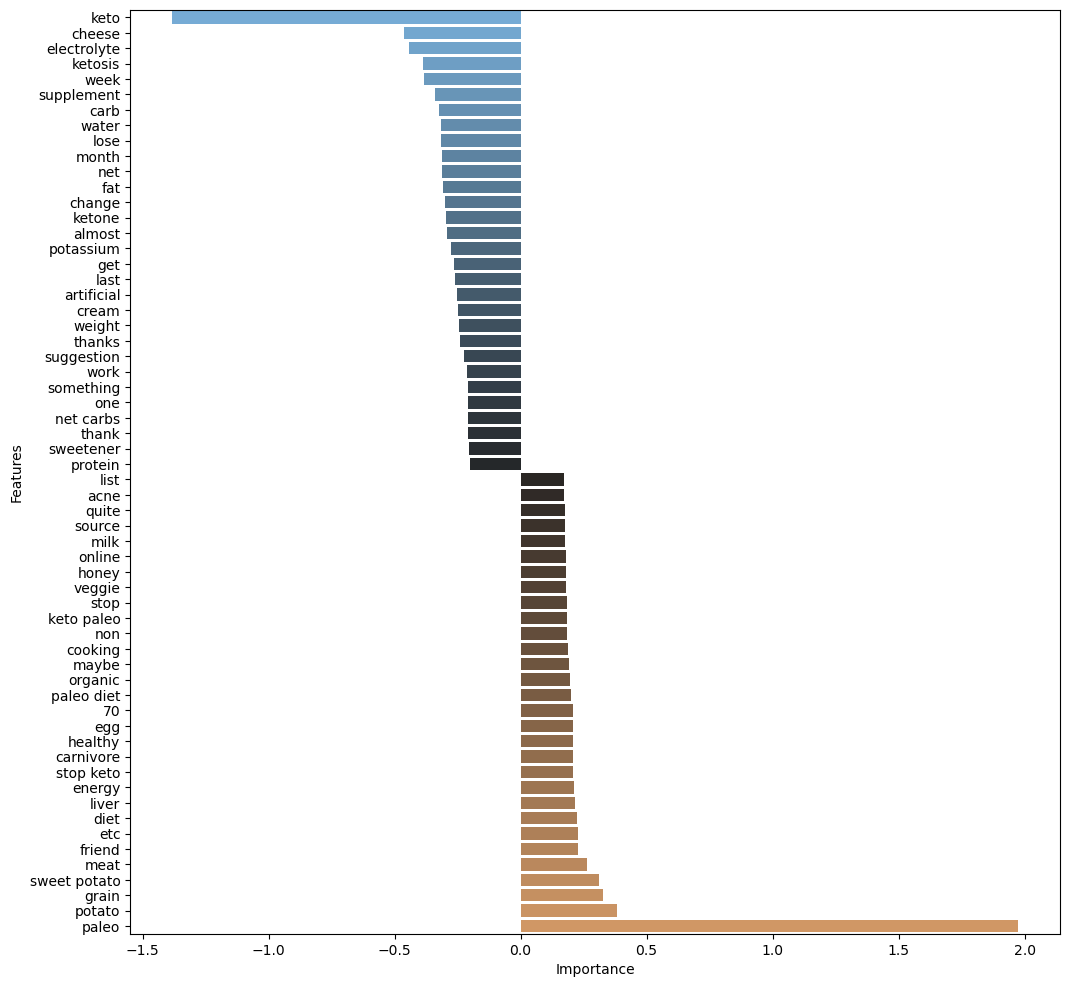

In [41]:
# Plot the selected features

plt.rcParams['figure.figsize'] = (12,12)
sns.barplot(data=selected_features.sort_values(by='Importance'), x='Importance',y='Features',orient='h',
            palette='ketopaleo')

plt.savefig('./images/feature.png', transparent=True)

In [42]:
# rebuild production model outside of the pipeline using hyperparameters from GridSearch
prod_cv = CountVectorizer(max_features = 5000, min_df = 3, max_df = .85, ngram_range = (1,2))
prod_X_train = prod_cv.fit_transform(X_train).toarray() 
prod_X_test = prod_cv.transform(X_test).toarray()

In [43]:
prod_train_df = pd.DataFrame(prod_X_train)
prod_train_df.columns = features


In [44]:
prod_lr = LogisticRegression(C = 0.1, penalty = 'l2')

prod_model_full = prod_lr.fit(prod_train_df, y_train)

In [45]:
# explain the model's predictions using SHAP

explainer = shap.KernelExplainer(prod_lr.predict_proba, shap.sample(prod_train_df,10))
shap_values = explainer.shap_values(shap.sample(prod_train_df,10))

X does not have valid feature names, but LogisticRegression was fitted with feature names


  0%|          | 0/10 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


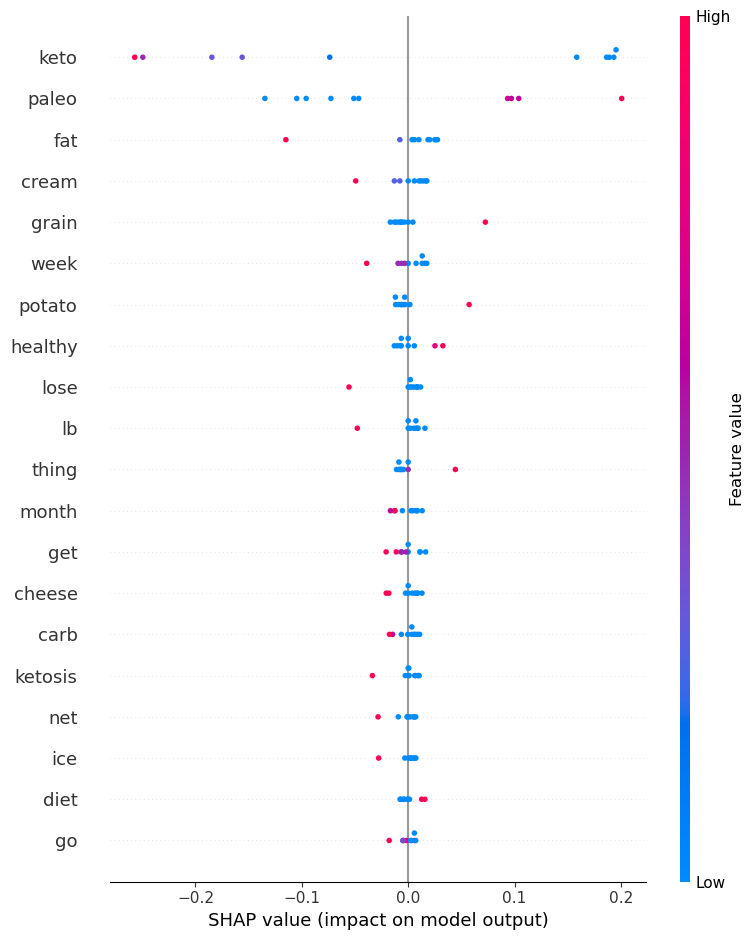

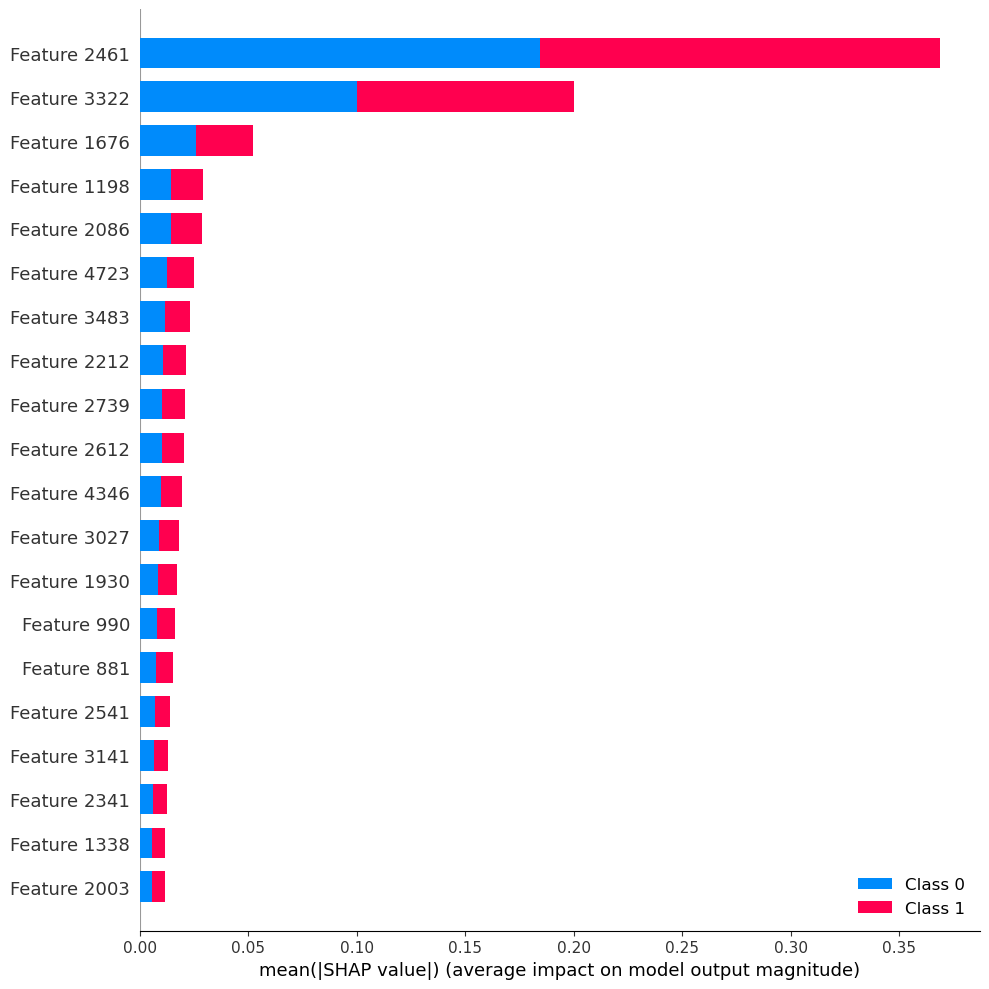

In [82]:
# visualise the first prediction's explanation 
shap.initjs()
shap.summary_plot(shap_values[1], shap.sample(prod_train_df,10))
fig1 = shap.summary_plot(shap_values, show=False, plot_type="bar", plot_size=(10, 10))


In [81]:
# visualise the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0], shap.sample(prod_train_df,10))



### B. Confusion Matrix

<a id='cm'></a>

In [ ]:
test_accuracy = accuracy_score(y_test,y_pred_cv_lr)
precision = precision_score(y_test, y_pred_cv_lr)
recall = recall_score(y_test, y_pred_cv_lr)

In [ ]:
# Visualizing the confusion matrix
cm = confusion_matrix(y_test, y_pred_cv_lr)
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=modified_cm,
            fmt='',
            annot_kws={"size": 12},
            linewidths=0.5,
            square=True,
            xticklabels = ['Keto', 'Paleo'],
            yticklabels = ['Keto', 'Paleo'],
            cmap='Blues')
plt.ylabel('Actual label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Accuracy Score: {:.3f}'.format(test_accuracy) + '\n'
          + 'Precision: {:.3f}'.format(precision) + '\n'
          + 'Recall: {:.3f}'.format(recall) +'\n', size=15)
plt.tick_params(labelsize=12)

plt.savefig('./images/confusionmatrix.png', transparent=True)

### C. ROC-AUC 

<a id='roc_auc'></a>

In [ ]:
# plot roc curve
# The ROC curve is a plot of the True Positive Rate (sensitivity) vs. the False Positive Rate (1 - specificity)
# for all possible decision thresholds
roc_display = RocCurveDisplay.from_estimator(gs_cv_lr, X_test,y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

plt.savefig('./images/rocauc.png', transparent=True)

### Summary

1) <b>Differing Focus</b>

    - The two communities exhibit distinct priorities, with the Keto community placing significant emphasis on macronutrient composition and micronutrients, whereas the Paleo community directs its attention towards ingredient choices.

2) <b>Shared Themes</b>

    - The prevalence of the terms ‘weight loss’ and ‘low carb’ in both communities suggests that weight management and adopting a low-carbohydrate dietary approach are central themes and objectives within both communities.

3) <b>Navigating Uncertainty</b>

    - Within both the Keto and Paleo communities, a considerable number of users express confusion regarding specific dietary details. The presence of confusion suggests that users may encounter challenges in understanding and implementing the intricate nuances associated with these dietary approaches.

## 6. Business Recommendations

<a id='biz_rec'></a>


1) <b>Dynamic Tracking</b>

    - By utilizing our final binary classifier, we can conduct an in-depth analysis of the user's historical comments and reviews. Leveraging this analysis, our website will seamlessly generate personalized product recommendations, meticulously curated to match their distinctive requirements and preferences. By understanding their ever changing preferences, we can develop and suggest products that align with their individual, and evolving requirements, ensuring a more satisfying and customized experience. 

        * Based on our insights, the Keto audience is likely to find products that offer convenient, high-fat, low-carb meal options attractive. We can focus on developing and promoting meals designed to include a combination of macronutrients in appropriate proportions, whilst incorporating a variety of nutrient-dense foods as well as supplements with a focus on micronutrients to ensure our customers are getting a wide range of essential vitamins, minerals, and antioxidants. 

        * The Paleo audience on the other hand will find products using high-quality, unprocessed ingredients that are aligned with ancestral diet principles more appealing. Following this insight, we can place more emphasis on sourcing and recommending organically and locally grown produce, grass-fed meats, wild-caught fish, pasture-raised eggs, etc.

2) <b>Broaden Appeal</b>

    - By capitalizing on shared interests, we can leverage it to enhance the appeal of each product, catering to a wider customer base:
    
        * Example 1: Whenever possible, develop and promote products specifically tailored to support weight loss and low-carb diets. This can include meal replacement options, low-carb snacks, dietary supplements, or specialized recipe ingredients. Ensuring that the nutritional content aligns with the needs of both Keto and Paleo practitioners will appeal to a broader customer base.
        
        * Example 2: Since both the Keto and Paleo communities are concerned about weight loss, it is imperative to ensure that all products bear conspicuous calorie labeling, both on physical packaging and online platforms. This measure is designed to streamline the caloric tracking process for customers, making it effortless to accurately monitor their calorie intake.
        
        * Example 3: We can capitalize on the current trending topics within each community as a means to expand our customer base. One such example is the 'Keto Month Challenge,' an initiative aimed at motivating individuals to adopt the ketogenic diet for a month. By offering guidance, resources, and support to participants throughout their journey, we have the opportunity to introduce and showcase our products to this target audience. Successfully converting individuals to the ketogenic diet can lead to a significant increase in our customer base.

3) <b>Educational Content</b>

    - By taking advantage of the information-seeking behavior of both communities, an opportunity arises to consistently deliver compelling and relevant content. This, in turn, fosters customer loyalty and sustains an actively engaged customer base. 
    - We can offer educational resources, comprehensive guides, and informative content to cater to the different communities. By crafting targeted marketing campaigns and messaging that highlight the macronutrient composition requirements and micronutrients concerns of the Keto community and ingredient selection preferences of the Paleo community, our business will be able to resonate with the respective audiences. 
    - This can be accomplished through various mediums such as well-researched blog articles, instructive videos, and carefully curated recipes that not only elucidate the fundamental principles underlying these dietary approaches but also offer practical tips for successful implementation. 



## 7. Conclusion

<a id='conclusion'></a>

Upon revisiting the problem statement, we are reminded of our two primary objectives:

1) <b>Objective 1</b>

    - Our first objective was to create a highly robust binary classifier with the ability to discern posts and content that are relevant to the Keto and Paleo diets. 

     - With an impressive F1-Score of 0.93, our model empowers our company's product and marketing teams to accurately ascertain the needs and preferences of our valued clientele. This invaluable insight enables us to tailor our offerings in accordance with the evolving requirements of our customers. By adopting this data-driven and personalized marketing approach, we anticipate an elevation in customer satisfaction levels, leading to substantial business growth.

2) <b>Objective 2</b>

    - Our second objective was to extract valuable insights pertaining to the characteristics and preferences of the Keto and Paleo communities. 

    - Through meticulous analysis of the gathered data, we successfully identified crucial insights that have played a pivotal role in guiding our marketing initiatives and product. 

<b> End of Part III</b> 